In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq espiownage fastai wwf # upgrade fastai on colab

# segmentation regression - camvid test

This is a straight-up COPY of [Zach Mueller's Walk With Fast AI Lesson 4 - Image Segmentation](https://walkwithfastai.com/Segmentation), EXCEPT we'll make it into a segmentation REGRESSION model (with one "class"), instead of classification (with 30 classes).  The dataset is CAMVID.  

(In a different notebook TBD, I'll switch to my own data.)

In [ ]:
#all_slow

# Libraries

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish   # MishJIT gives me trouble :-( 
from fastai.losses import BaseLoss, MSELossFlat, CrossEntropyLossFlat, BCEWithLogitsLossFlat
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

In [ ]:
!nvidia-smi

Sun Sep 12 19:06:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     6W /  N/A |      8MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.is_available()

True

## Dataset

Todays dataset will be `CAMVID`, which is a segmentation based problem from cameras on cars to segment various areas of the road

In [ ]:
path = untar_data(URLs.CAMVID)

Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:

In [ ]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [ ]:
valid_fnames[:5]

['0016E5_07959.png',
 '0016E5_07961.png',
 '0016E5_07963.png',
 '0016E5_07965.png',
 '0016E5_07967.png']

Let's look at an image and see how everything aligns up

In [ ]:
path_im = path/'images'
path_lbl = path/'labels'

First we need our filenames

In [ ]:
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)

And now let's work with one of them

<AxesSubplot:>

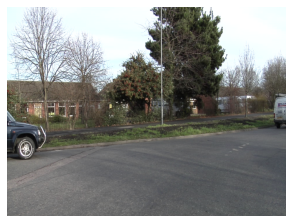

In [ ]:
img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

Now let's grab our y's. They live in the `labels` folder and are denoted by a `_P`

In [ ]:
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

The stem and suffix grab everything before and after the period respectively.

Our masks are of type `PILMask` and we will make our gradient percentage (alpha) equal to 1 as we are not overlaying this on anything yet

<AxesSubplot:>

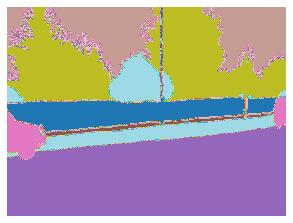

In [ ]:
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

Now if we look at what our mask actually is, we can see it's a giant array of pixels:

In [ ]:
tensor(msk)

tensor([[21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        [21, 21, 21,  ..., 21, 21, 21],
        ...,
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17],
        [17, 17, 17,  ..., 17, 17, 17]], dtype=torch.uint8)

Where each one represents a class that we can find in `codes.txt`. Let's make a vocabulary with it

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
yrange = len(codes); yrange

32

We need a split function that will split from our list of valid filenames we grabbed earlier. Let's try making our own.

In [ ]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

splits between training and validation sets.  FuncSplitter returns true for validation set items, false otherwise. 

This takes in our filenames, and checks for all of our filenames in all of our items in our validation filenames

## Transfer Learning between DataSets

Jeremy popularized the idea of image resizing:
* Train on smaller sized images
* Eventually get larger and larger
* Transfer Learning loop

This first round we will train at half the image size

In [ ]:
sz = msk.shape; sz

(720, 960)

In [ ]:
half = tuple(int(x/2) for x in sz); half

(360, 480)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = camvid.dataloaders(path/'images', bs=4)

/home/sstudent/envs/espi/lib/python3.9/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/sstudent/envs/espi/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = 

Let's look at a batch, and look at all the classes between codes 1 and 30 (ignoring `Animal` and `Wall`)

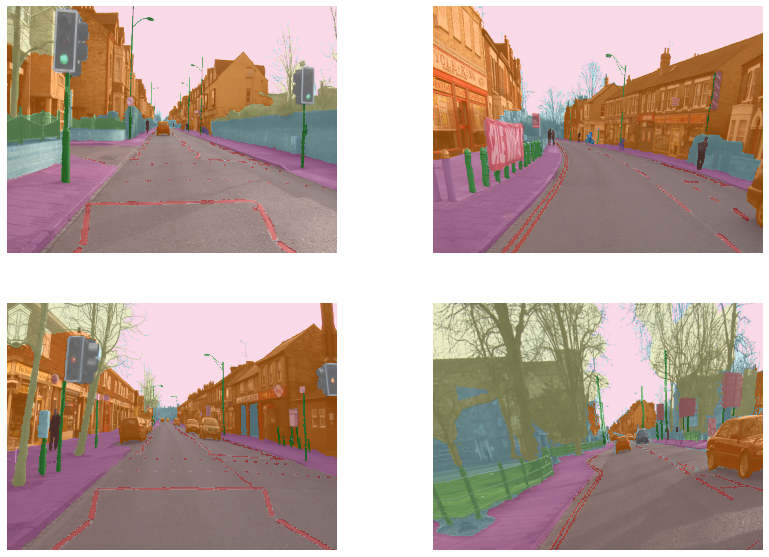

In [ ]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

Lastly let's make our vocabulary a part of our `DataLoaders`, as our loss function needs to deal with the `Void` label

In [ ]:
dls.vocab = codes

Now we need a methodology for grabbing that particular code from our output of numbers. Let's make everything into a dictionary

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

In [ ]:
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'SUVPickupTruck': 22,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

Awesome! Let's make an accuracy function

In [ ]:
void_code = name2id['Void']

For segmentation, we want to squeeze all the outputted values to have it as a matrix of digits for our segmentation mask. From there, we want to match their argmax to the target's mask for each pixel and take the average

In [ ]:
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

def acc_camvid_reg(inp, targ):
    targ = targ.squeeze(1)
    # 1 - pixelwise error rate (within +/- 0.5 of each other). note this includes voids
    #return 1 - (inp-targ).abs().round().type(torch.IntTensor).type(torch.FloatTensor).mean() # nope error's too big
    #return 1 - torch.count_nonzero( (inp-targ).abs().round().type(torch.IntTensor) ) / inp.numel()
    return 1 - (inp-targ).abs().round().clamp(max=1).mean() 

## The Dynamic Unet

![](http://tuatini.me/content/images/2017/09/u-net-architecture.png)

[image source](https://r.search.yahoo.com/_ylt=AwrExdqB0utfdJIAiU.jzbkF;_ylu=c2VjA2ZwLWF0dHJpYgRzbGsDcnVybA--/RV=2/RE=1609319169/RO=11/RU=https%3a%2f%2ftuatini.me%2fpractical-image-segmentation-with-unet%2f/RK=2/RS=ZXDe1xIW7NgnEcZwMcj9.YgKmG4-)

U-Net allows us to look at pixel-wise representations of our images through sizing it down and then blowing it bck up into a high resolution image. The first part we call an "encoder" and the second a "decoder"

On the image, the authors of the UNET paper describe the arrows as "denotions of different operations"

We have a special `unet_learner`. Something new is we can pass in some model configurations where we can declare a few things to customize it with!

* Blur/blur final: avoid checkerboard artifacts
* Self attention: A self-attention layer
* y_range: Last activations go through a sigmoid for rescaling
* Last cross - Cross-connection with the direct model input
* Bottle - Bottlenck or not on that cross
* Activation function
* Norm type

Let's make a `unet_learner` that uses some of the new state of the art techniques. Specifically:

* Self-attention layers: `self_attention = True`
* Mish activation function: `act_cls = Mish`

Along with this we will use the `Ranger` as optimizer function.

In [ ]:
opt = ranger

# UNet_learner,...

In [ ]:
#learn = unet_learner(dls, resnet34, yrange=len(codes), loss_func=MSELossFlat(), metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)
learn = unet_learner(dls, resnet34, n_out=1, y_range=(0,len(codes)), loss_func=MSELossFlat(), metrics=acc_camvid_reg, self_attention=True, act_cls=Mish, opt_func=opt)

/home/sstudent/envs/espi/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
learn.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

If we do a `learn.summary` we can see this blow-up trend, and see that our model came in frozen. Let's find a learning rate

/home/sstudent/envs/espi/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


Suggested Learning Rate = 0.0002290867705596611


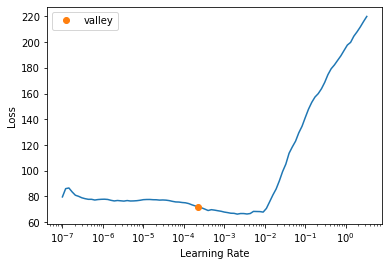

In [ ]:
lr = learn.lr_find().valley
print("Suggested Learning Rate =",lr)

In [ ]:
#lr = 1e-3

With our new optimizer, we will also want to use a different fit function, called `fit_flat_cos`

In [ ]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid_reg,time
0,32.222607,23.294327,0.273558,01:15
1,23.570961,19.469526,0.285177,01:17
2,20.218534,17.931406,0.407681,01:18
3,18.251694,17.461021,0.455742,01:20
4,17.303759,17.610416,0.419639,01:20
5,15.384972,15.757072,0.463149,01:22
6,15.123032,16.662140,0.507286,01:21
7,14.797538,15.853521,0.536766,01:21
8,12.451121,16.454145,0.553998,01:22
9,11.744457,16.561687,0.569311,01:22


^^ Looks like we're getting some overfitting, meaning the model's not learning well enough. :-(  

Final accuracy score for this part of [Zach's classification-segmentation notebook](https://walkwithfastai.com/Segmentation) was > 91%. 

In [ ]:
learn.save('stage-1')   # Zach saves in case Colab dies / gives OOM
learn.load('stage-1');  # he reloads as a way of skipping what came before if he restarts the runtime.

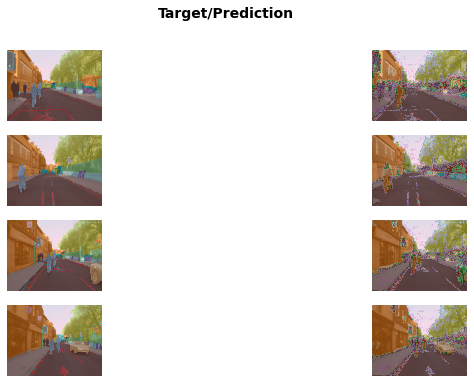

In [ ]:
learn.show_results(max_n=4, figsize=(12,6))

Let's unfreeze the model and decrease our learning rate by 4 (Rule of thumb)

In [ ]:
lrs = slice(lr/400, lr/4)

In [ ]:
lr, lrs

(0.0002290867705596611,
 slice(5.727169263991528e-07, 5.727169263991527e-05, None))

In [ ]:
learn.unfreeze()

And train for a bit more

In [ ]:
learn.fit_flat_cos(12, lrs)

epoch,train_loss,valid_loss,acc_camvid_reg,time
0,11.265100,17.162098,0.580566,01:19
1,11.012714,17.208702,0.593603,01:20
2,10.797048,17.459799,0.582573,01:22
3,10.516537,16.591791,0.598544,01:24
4,10.107773,16.962065,0.594523,01:24
5,9.963783,17.510872,0.585985,01:25
6,9.782438,16.837233,0.595724,01:26
7,9.837771,16.311815,0.592538,01:25
8,9.841679,16.733191,0.581369,01:25
9,9.377201,17.109062,0.595153,01:25


^Yuck. Definitely overfitting. 

In [ ]:
learn.save('model_1')

Path('models/model_1.pth')

And look at a few results

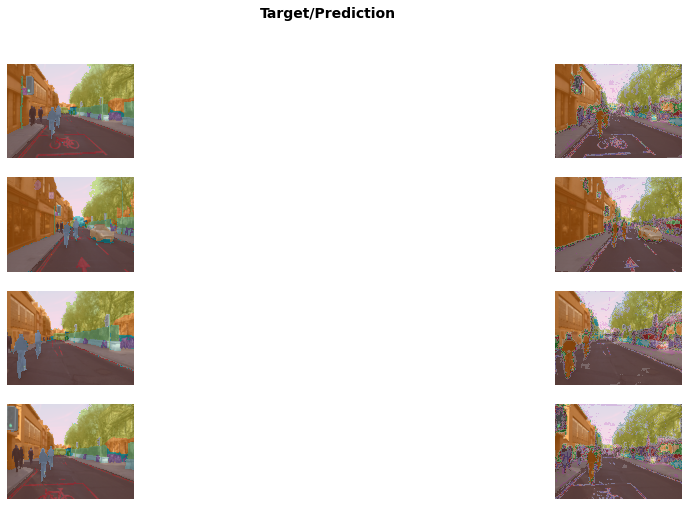

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

So it WORKS, just not nearly as cleanly as the classification version. (Compare similar images in Zach's original notebook) 

## Inference

Let's take a look at how to do inference with `test_dl`

In [ ]:
dl = learn.dls.test_dl(fnames[:5]) 

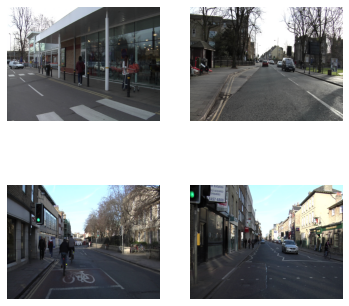

In [ ]:
dl.show_batch()

Let's do the first five pictures

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0].shape

torch.Size([5, 1, 360, 480])

Alright so we have a 5x1x360x480, just like we wanted

What does this mean? We had five images, so each one is one of our five images in our batch. Let's look at the first

In [ ]:
pred_1 = preds[0][0].squeeze()

In [ ]:
pred_1.shape

torch.Size([360, 480])

And look at the mask:

<AxesSubplot:>

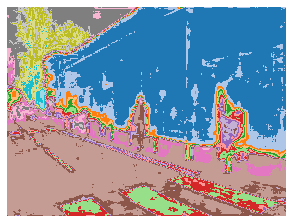

In [ ]:
msk = PILMask.create(pred_1)
msk.show(figsize=(5,5), alpha=1)

What do we do from here? We need to save it away. We can do this one of two ways, as a numpy array to image, and as a tensor (to say use later rawly)

## ^^student stopped here.

I didn't run the rest of Zach's notebook beyond this point.

----

In [ ]:
pred_arx = pred_arx.numpy()

In [ ]:
rescaled = (255.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)

In [ ]:
im = Image.fromarray(rescaled)

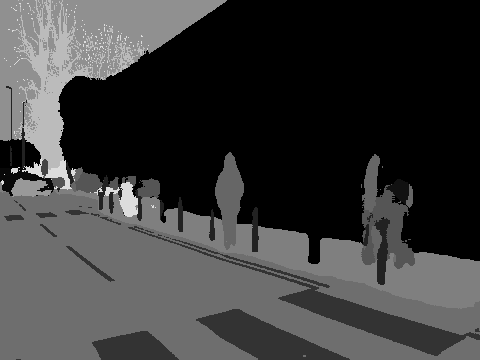

In [ ]:
im

In [ ]:
im.save('test.png')

Let's make a function to do so for our files

In [ ]:
for i, pred in enumerate(preds[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

Now let's save away the raw:

In [ ]:
torch.save(preds[0][0], 'Image_1.pt')

In [ ]:
pred_1 = torch.load('Image_1.pt')

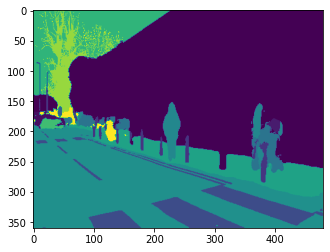

In [ ]:
plt.imshow(pred_1.argmax(dim=0))

## Full Size (Homework)

Now let's go full sized. Restart your instance to re-free your memory

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)
valid_fnames = (path/'valid.txt').read_text().split('\n')
get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

And re-make our dataloaders. But this time we want our size to be the full size

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=sz), Normalize.from_stats(*imagenet_stats)])

We'll also want to lower our batch size to not run out of memory

In [ ]:
dls = camvid.dataloaders(path/"images", bs=1)

Let's assign our vocab, make our learner, and load our weights

In [ ]:
opt = ranger

In [ ]:
dls.vocab = codes
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('model_1');

And now let's find our learning rate and train!

SuggestedLRs(valley=9.120108734350652e-05)

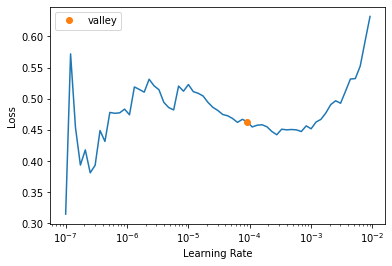

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.471550,0.368950,0.896839,06:23
1,0.383102,0.317719,0.910819,06:26
2,0.349842,0.292281,0.917400,06:27
3,0.312502,0.276823,0.929146,06:27
4,0.286605,0.302931,0.918379,06:28
5,0.278865,0.274219,0.922917,06:26
6,0.268625,0.274024,0.927774,06:26
7,0.243806,0.294277,0.921766,06:25
8,0.214576,0.273785,0.930623,06:25
9,0.161056,0.263526,0.932464,06:25


In [ ]:
learn.save('full_1')

Path('models/full_1.pth')

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10); lrs

slice(1e-06, 0.0001, None)

In [ ]:
learn.fit_flat_cos(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.177898,0.261041,0.932283,06:40
1,0.176739,0.265588,0.932579,06:40
2,0.161004,0.251770,0.935003,06:39
3,0.170621,0.243927,0.935881,06:38
4,0.151459,0.267997,0.932118,06:38
5,0.158537,0.268057,0.933528,06:38
6,0.148051,0.260733,0.933867,06:38
7,0.159659,0.249256,0.934802,06:38
8,0.151944,0.250918,0.934819,06:38
9,0.140946,0.251948,0.935812,06:38


In [ ]:
learn.save('full_2')

Path('models/full_2.pth')

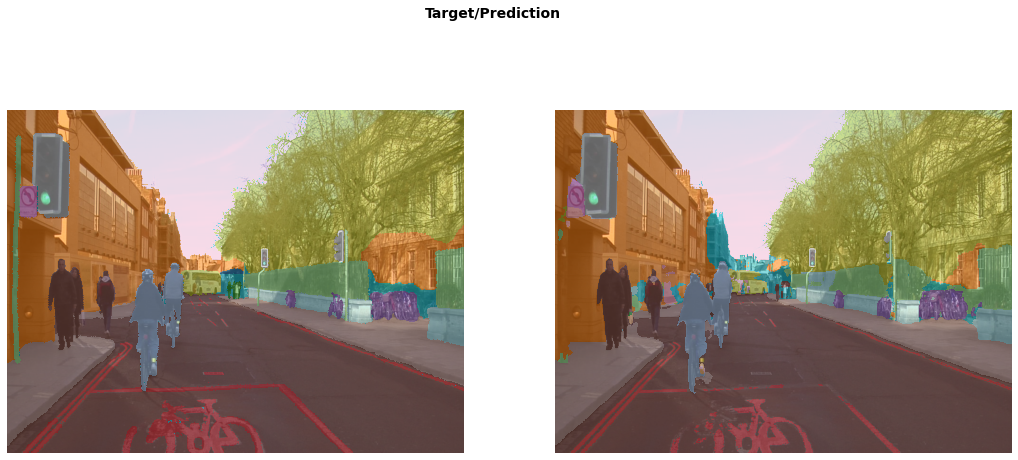

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

## Weighted Loss Functions

We can use weighted loss functions to help with class imbalancing. We need to do this because simply oversampling won't quite work here! So, how do we do it? `fastai`'s `CrossEntropyLossFlat` is just a wrapper around `PyTorch`'s `CrossEntropyLoss`, so we can pass in a `weight` parameter (even if it doesn't show up in our autocompletion!) 




In [ ]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

But what should this weight be? It needs to be a 1x`n` tensor, where `n` is the number of classes in your dataset. We'll use a quick example, where all but the last class has a weight of 90% and the last class has a weight of 110%

Also, as we are training on the GPU, we need the tensor to be so as well:

In [ ]:
weights = torch.tensor([[0.9]*31 + [1.1]]).cuda()

In [ ]:
weights

tensor([[0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000, 0.9000, 0.9000, 0.9000, 1.1000]], device='cuda:0')

Now we can pass this into `CrossEntropyLossFlat`

* **Note**: as this is segmentation, we need to make the axis to 1

In [ ]:
learn.loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

(or to pass it into `cnn_learner`)

In [ ]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [ ]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, loss_func=loss_func)